In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
import re
import gc
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

In [2]:
# Load the data
import json
import collections

datadict = collections.defaultdict(dict)
for record in SeqIO.parse("disprot_OK_fullset.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['seq'] = seq

for record in SeqIO.parse("disprot_OK_fullset_annotations.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['disorder'] = seq

print(f"Loaded {len(datadict.keys())} proteins")

Loaded 2145 proteins


In [3]:
AA2num = dict(zip(sorted(list(set([i for i in datadict["P19793"]['seq']]))),np.arange(20)))
AA2num['</s>'] = 20
AA2num['X'] = 21
num2AA = dict(zip(np.arange(20),sorted(list(set([i for i in datadict["P19793"]['seq']])))))
num2AA[20] = "</s>"
num2AA[21] = "X"
AAsize = len(list(AA2num.keys()))

uniprots = list(datadict.keys())
delcounter = 0
for unip in uniprots:
    lossfile = f"loss/{unip}.json"
    if os.path.exists(lossfile):
        #print(unip)
        with open(lossfile) as instrm:
            lossdict = json.load(instrm)
        datadict[unip]["aamask_1"] = lossdict[unip]["aamask_1"]
    else:
        del(datadict[unip])
        delcounter += 1

print(f"Loaded {len(datadict.keys())} proteins")

Loaded 2145 proteins


In [27]:
relpos_acum  = collections.defaultdict(int)
relpos_acumL = collections.defaultdict(int)

intervals = [100, 300, 500, 600, 700, 800, 900, 1000]
relpos_strati = collections.defaultdict(dict)
for i in intervals:
    relpos_strati[i] = collections.defaultdict(int)
protlengths = list()
for unip in datadict:
    L = len(datadict[unip]['seq'])
    protlengths.append(L)
    this_seq = datadict[unip]['seq']
    diso_ix = [True if e != "-" else False for e in datadict[unip]['disorder'] ]
    loss = np.array(datadict[unip]['aamask_1']['loss'])
    matches = datadict[unip]['aamask_1']['match']
    seq_pos = np.arange(len(matches))
    for pos,e in enumerate(matches):
        if e == True:
            continue
        else:
            for mismatch_aa in e:
                relpos = mismatch_aa[0] - pos
                relpos_acum[relpos] += 1
                relpos_acumL[relpos] += 1/L
                for i in range(len(intervals)):
                    if i == (len(intervals)-1):
                        if L > intervals[i]:
                            relpos_strati[intervals[i]][relpos] += 1/L
                            break
                    else:
                        if L <= intervals[i]:
                            relpos_strati[intervals[i]][relpos] += 1/L
                            break
                        
                        

In [28]:
print(len(intervals))
print(intervals)
[i for i in range(len(intervals))]

8
[100, 300, 500, 600, 700, 800, 900, 1000]


[0, 1, 2, 3, 4, 5, 6, 7]

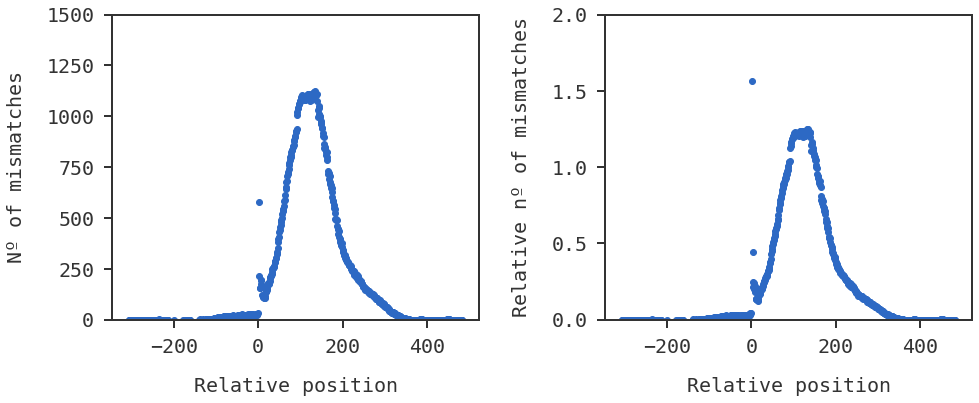

In [29]:
x = list(relpos_acum.keys())
y  = [relpos_acum[i] for i in relpos_acum.keys()]
yL = [relpos_acumL[i] for i in relpos_acumL.keys()]

fig = plt.figure(figsize=(14,6), dpi=72)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(x,y)
ax2.scatter(x,yL)
ax1.set_ylim(0,1500)
ax2.set_ylim(0,2)
ax1.set_xlabel("Relative position")
ax1.set_ylabel("Nº of mismatches")
ax2.set_xlabel("Relative position")
ax2.set_ylabel("Relative nº of mismatches")
plt.tight_layout()
plt.show()

In [30]:
for i in range(-5,15):
    print(i, relpos_acumL[i])


-5 0.03611964130689483
-4 0.035072703740844056
-3 0.04133336548907666
-2 0.02851393053216909
-1 0.0436650982760974
0 785.0149310736927
1 810.1008656401623
2 1.5613563339417689
3 0.4412355883976029
4 0.24907147718437372
5 0.21788526369536937
6 0.23912315241103788
7 0.19958032250973606
8 0.2210402506687026
9 0.1850415511441107
10 0.13911064125334097
11 0.134762899332776
12 0.13502199981458013
13 0.14394015263405344
14 0.12988691974060565


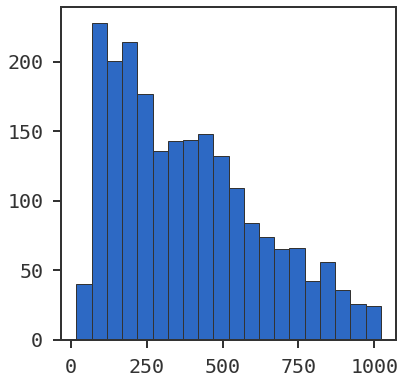

In [31]:
fig = plt.figure(figsize=(6,6), dpi=72)
ax = fig.add_subplot(111)
ax.hist(protlengths)
plt.show()

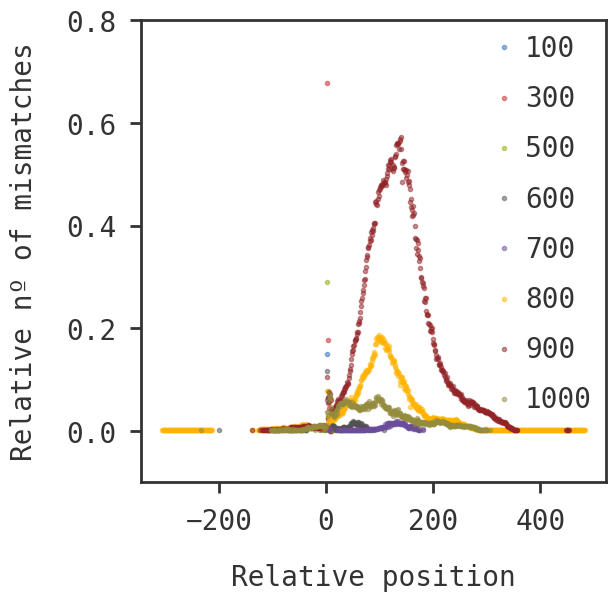

In [35]:

fig = plt.figure(figsize=(6,6), dpi=100)
ax1 = fig.add_subplot(111)
ints = list(relpos_strati.keys())
for k in ints:
    x = list(relpos_strati[k].keys())
    y  = [relpos_strati[k][i] for i in relpos_strati[k].keys()]
    ax1.scatter(x,y, label=k, marker=".", alpha=0.5)
ax1.set_ylim(-0.1,.8)
ax1.set_xlabel("Relative position")
ax1.set_ylabel("Relative nº of mismatches")
# plt.tight_layout()
plt.legend()
plt.show()

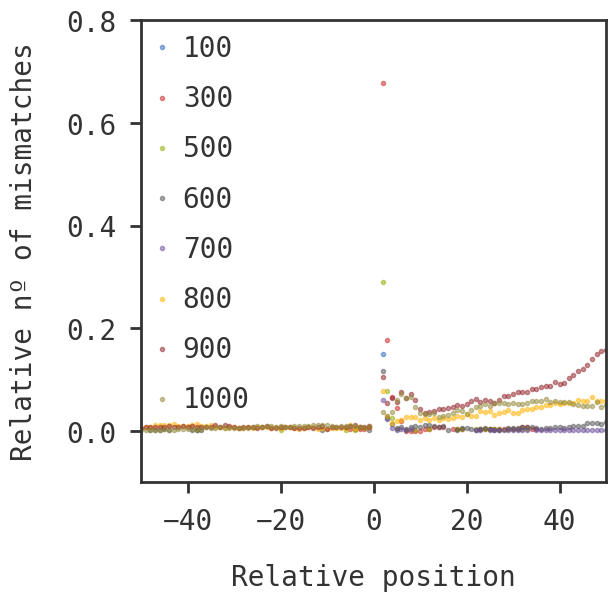

In [49]:
fig = plt.figure(figsize=(6,6), dpi=100)
ax1 = fig.add_subplot(111)
ints = list(relpos_strati.keys())
for k in ints:
    x = list(relpos_strati[k].keys())
    y  = [relpos_strati[k][i] for i in relpos_strati[k].keys()]
    ax1.scatter(x,y, label=k, marker=".", alpha=0.5)
ax1.set_ylim(-0.1,.8)
ax1.set_xlim(-50,50)
plt.legend()
ax1.set_xlabel("Relative position")
ax1.set_ylabel("Relative nº of mismatches")
plt.show()

In [36]:
for i in range(-5,15):
    print(i, relpos_strati[300][i])

-5 0.004608294930875576
-4 0.004608294930875576
-3 0.004608294930875576
-2 0.004608294930875576
-1 0.010456248147249846
0 298.4878932912753
1 305.286008403571
2 0.6773816975178752
3 0.1772857885171724
4 0.06625043455301687
5 0.04505678646614962
6 0.01940747448862771
7 0
8 0
9 0
10 0
11 0.004
12 0.003952569169960474
13 0.007889577043976222
14 0.007889577043976222


In [37]:
### Do a per-region analysis
import copy

def get_regions(diso_ix):
    local_acum = 0
    current_status = None
    this_regions = list()
    for e in diso_ix:
        if current_status is None:
            current_status = copy.copy(e)
            local_acum += 1
        if e is current_status:
            local_acum += 1
        else:
            this_regions.append([local_acum, current_status])
            current_status = e
            local_acum = 1
    this_regions.append([local_acum, current_status])
    return this_regions
    
for unip in datadict:
    L = len(datadict[unip]['seq'])
    protlengths.append(L)
    this_seq = datadict[unip]['seq']
    diso_ix = [True if e != "-" else False for e in datadict[unip]['disorder'] ]
    regions = get_regions(diso_ix) # [(378, False), (12, True), (38, False), (22, True), (63, False)]
    for r in regions:
        if r[1] == True:
            
    break


[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [47]:
get_regions(diso_ix)

[(378, False), (12, True), (38, False), (22, True), (63, False)]